# RO change over time

## Imports

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import src.XRO
import copy
import scipy.stats
import warnings
import calendar

# import gsw

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False}, palette="colorblind")

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def get_rolling_std(data, n=20):
    """
    Get standard deviation, computing over time and ensemble member. To increase
    sample size for variance estimate, compute over time window of 2n+1
    years, centered at given year.
    """

    ## do the computation
    kwargs = dict(fn=np.std, n=n, reduce_ensemble_dim=False)
    data_std = src.utils.get_rolling_fn_bymonth(data, **kwargs)

    ## unstack year and month
    data_std = src.utils.unstack_month_and_year(data_std)

    return data_std


def get_stats(x):
    """helper function to compute plotting bounds for experiment"""
    stats = x.quantile(q=[0.1, 0.5, 0.9], dim="member")
    return stats.rename({"quantile": "q"})


def get_fits_over_time(data_rolling, model, by_member=False, **fit_kwargs):
    """Get RO fits for each ensemble member as a function of time."""

    ## empty list to hold results
    fits = []

    ## loop through years
    for y in tqdm.tqdm(data_rolling.year):

        ## get data for year
        data_y = data_rolling.sel(year=y)

        if by_member:

            ## separate fit for each ensemble member
            fits_ = []
            for m in data_rolling.member:
                with warnings.catch_warnings(action="ignore"):
                    fits_.append(model.fit_matrix(data_y.sel(member=m), **fit_kwargs))
            fit = xr.concat(fits_, dim=data_y.member)

        else:

            ## fit for all ensemble members together
            with warnings.catch_warnings(action="ignore"):
                fit = model.fit_matrix(data_y, **fit_kwargs)

        ## track fits
        fits.append(fit.drop_vars(["time", "X", "Y", "Yfit"]))

    ## put back in xarray
    fits = xr.concat(fits, dim=data_rolling.year)

    return fits


def get_fits_over_time_wrapper(
    data_rolling, model, by_member=False, fname=None, **fit_kwargs
):
    """wrapper function to handle saving/loading"""

    ## function to compute fits
    get_fits = lambda: get_fits_over_time(
        data_rolling, model=model, by_member=by_member, **fit_kwargs
    )

    ## if fname not specified, compute without loading/saving
    if fname is None:
        fits = get_fits()

    else:

        ## get full filepath
        fp = pathlib.Path(os.environ["SAVE_FP"], "fits_cesm", fname)

        ## try to load pre-computed
        if fp.is_file():
            print("Loading pre-computed")
            fits = xr.open_dataset(fp)

        ## otherwise, compute and save
        else:
            fits = get_fits()
            fits.to_netcdf(fp)

    return fits

## Load data

### T, h

In [3]:
## open data
Th = src.utils.load_cesm_indices(load_z20=True, load_h_cust=True, max_grad=True)

## omit first year (bc of NaN in h,hw vars)
Th = Th.sel(time=slice("1851", None))

### preprocess

In [4]:
## standardize (for convenience)
Th /= Th.std()

## get windowed data (used to estimate change in parameters over time)
Th_rolling = src.utils.get_windowed(Th, window_size=480, stride=120)

## compute grad
Th_rolling["dTdx"] = Th_rolling["T_3"] - Th_rolling["T_4"]

#### Remove SST dependence

In [5]:
for T_var, h_var in zip(["T_3", "T_34"], ["h_w", "h_w_z20"]):
    Th_rolling[f"{h_var}_hat"] = src.utils.remove_sst_dependence_v2(
        Th_rolling,
        T_var=T_var,
        h_var=h_var,
        dims=["time", "member"],
    )

#### Scale by alpha

In [6]:
alpha_scale = xr.open_dataarray(
    pathlib.Path(SAVE_FP, "cesm_alpha_scale.nc"),
)
Th_rolling["h_w_alpha-scaled"] = Th_rolling["h_w"] * alpha_scale
Th_rolling["h_w_hat_alpha-scaled"] = Th_rolling["h_w_hat"] * alpha_scale

#### Scale by $\overline{h}$

In [7]:
hbar_scale = xr.open_dataarray(
    pathlib.Path(SAVE_FP, "cesm_Hbar_scale.nc"),
)
Th_rolling["h_w_Hbar-scaled"] = Th_rolling["h_w"] * hbar_scale
Th_rolling["h_w_hat_Hbar-scaled"] = Th_rolling["h_w_hat"] * hbar_scale

## Compute time-varying RO parameters

In [8]:
## specify filename for saving (if None, then don't save/load)
FNAME = "T3_h_w_Hbar_scaled"
# FNAME = "T3_h_w"
# FNAME = "T34_h_w_Hbar_scaled_fix-ac"

## should we use forward differences to estimate operator?
IS_FORWARD = True

## specify variables
varnames = ["T_3", "h_w_Hbar-scaled"]
# varnames = ["T_3", "h_w"]
# varnames = ["T_34", "h_w_Hbar-scaled"]

## fit for each ensemble member differently
BY_MEMBER = False

## parameters for fitting
MODEL = src.XRO.XRO(ncycle=12, ac_order=5, is_forward=IS_FORWARD)
fit_kwargs = dict(ac_mask_idx=None, maskNT=[])
# fit_kwargs = dict(ac_mask_idx=[(0,1),(1,0),(1,1)], maskNT=[])

## get fits
fits = get_fits_over_time_wrapper(
    Th_rolling[varnames],
    model=MODEL,
    by_member=BY_MEMBER,
    fname=FNAME,
    **fit_kwargs,
)

## extract parameters
params = src.utils.get_params(fits=fits, model=MODEL)

## get change from initial period
delta_params = params - params.isel(year=0)

Loading pre-computed


## Validate changes in variance over time

### Estimate variance of RO model over time

In [9]:
def get_RO_sigma(model, params, **simulation_kwargs):
    """Compute stats (e.g., standard deviation) for RO parameters over time"""

    output = model.simulate(fit_ds=params, **simulation_kwargs)

    return output.groupby("time.month").std()


def get_RO_sigma_over_time(model, params, **simulation_kwargs):
    """Compute stats over time"""

    ## take ensemble mean if necessary
    if "member" in params.dims:
        params = params.mean("member")

    ## empty list to hold result
    sigmas = []

    ## loop through years
    for y in tqdm.tqdm(params.year):

        ## specs for simulation
        kwargs = dict(
            simulation_kwargs,
            model=model,
            params=params.sel(year=y),
        )

        ## do the simulation
        sigmas.append(get_RO_sigma(**kwargs))

    ## put back in xarray
    sigmas = xr.concat(sigmas, dim=params.year)

    return sigmas

In [10]:
## should we use noise covariance
USE_NOISE_COV = False

## simulation specs
simulation_kwargs = dict(
    nyear=40,
    ncopy=50,
    seed=1000,
    X0_ds=Th_rolling[varnames].isel(year=0, member=0, time=0),
    noise_type="white",
    use_noise_cov=USE_NOISE_COV,
    is_xi_stdac=True,
)

## compute with parameters estimated from all ensemble members
RO_sigma_over_time_v2 = get_RO_sigma_over_time(
    model=MODEL, params=fits, **simulation_kwargs
)

100%|██████████| 22/22 [00:05<00:00,  3.87it/s]


### estimate variance of CESM over time

In [11]:
## compute rolling std
# Th_std = get_rolling_std(Th, n=20)
Th_std = Th_rolling.groupby("time.month").std("time")

## compute percentage change in std
baseline = Th_std.isel(year=0).mean("member")
delta_Th_std = 100 * (Th_std - baseline) / baseline

### Compare model and RO

Function to plot results

In [12]:
def plot_stats_comp(ax, list_of_stats, labels, colors=None, n=varnames[0]):
    """plot comparison of variance over time"""

    if colors is None:
        colors = sns.color_palette()[: len(list_of_stats)]

    for stats, label, c in zip(list_of_stats, labels, colors):

        ## plot median
        mplot = ax.plot(stats.year, stats[n].sel(q=0.5), lw=2.5, label=label, c=c)

        ## plot lower/upper quantiles
        kwargs = dict(c=mplot[0].get_color(), lw=0.8)
        for q in stats.q:
            if q != 0.5:
                ax.plot(stats.year, stats[n].sel(q=q), **kwargs)

    ## label and set plotting specs
    ax.set_xlabel("Year")
    ax.set_ylabel(r"$\sigma_T$ ($^{\circ}$C)")
    ax.set_ylim([0.3, 1.7])
    ax.set_xticks([1870, 1975, 2080])
    ax.set_yticks([0.6, 1.2])

    return


def format_validation_plots(axs):
    """add formatting to CESM v. RO plot"""

    axs[1, 0].set_ylabel(r"$\sigma_h$($^{\circ}$C)")
    axs[0, 1].legend(prop=dict(size=8))
    for i in range(axs.shape[1]):
        ## remove ticks
        axs[0, i].set_xticks([])
        axs[0, i].set_xlabel(None)
        if i > 0:
            for ax in axs[:, i]:
                ax.set_yticks([])
                ax.set_ylabel(None)

    return

Make the plot

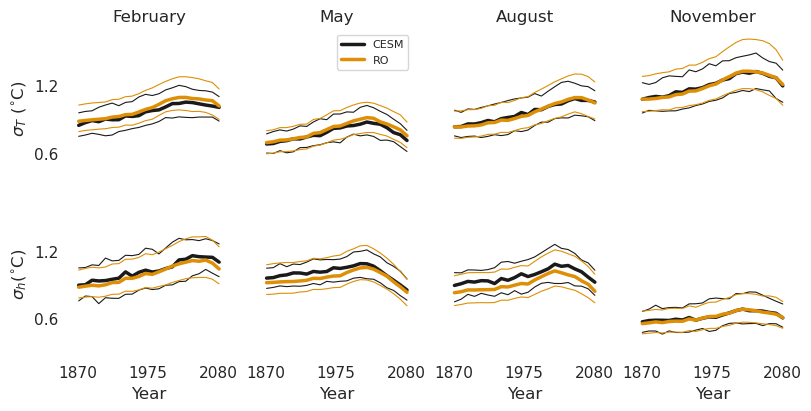

In [13]:
## specify months to plot
PLOT_MONTHS = [2, 5, 8, 11]

fig, axs = plt.subplots(2, 4, figsize=(8, 4), layout="constrained")

for i, m in enumerate(PLOT_MONTHS):

    ## compute stats
    stats_mpi = get_stats(Th_std).sel(month=m)
    stats_ro_v2 = get_stats(RO_sigma_over_time_v2).sel(month=m)

    ## specify kwargs
    plot_kwargs = dict(
        list_of_stats=[stats_mpi, stats_ro_v2],
        labels=["CESM", "RO"],
        colors=["k", sns.color_palette()[1]],
    )

    ## plot comparison
    for j, ax in enumerate(axs[:, i]):
        plot_stats_comp(ax, n=varnames[j], **plot_kwargs)

    ## label
    axs[0, i].set_title(calendar.month_name[m])

## format all subplots
format_validation_plots(axs)

plt.show()

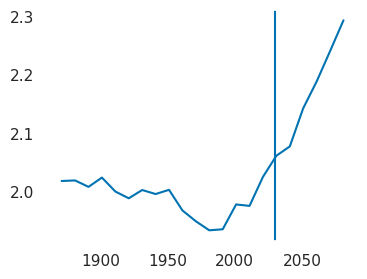

In [14]:
fig, ax = plt.subplots(figsize=(4, 3))
# ax.plot(params.year, params.R.mean("cycle") - 0.08)
ax.plot(params.year, params.epsilon.mean("cycle") - 0.08)
# ax.plot(params.year, params.R.mean("cycle")-.56)
# ax.plot(params.year, params.BJ_ac.mean("cycle")+1.7)
# ax.plot(stats_mpi.year, get_stats(Th_std["T_3"]).sel(q=0.5).mean("month"))
ax.axvline(2030)

### Plot diagnostics

### Snapshots of parameters over time

In [15]:
def format_params_line(axs):
    """format line plots of parameters"""
    for ax in axs:

        ax.axhline(0, ls="--", c="k", lw=0.8)
        ax.set_xticks([2, 11])

    return

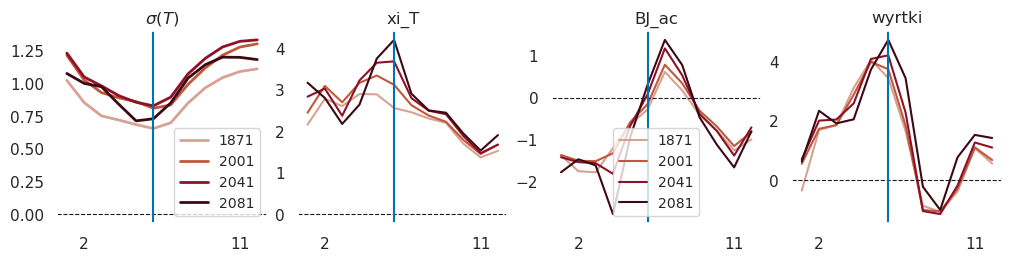

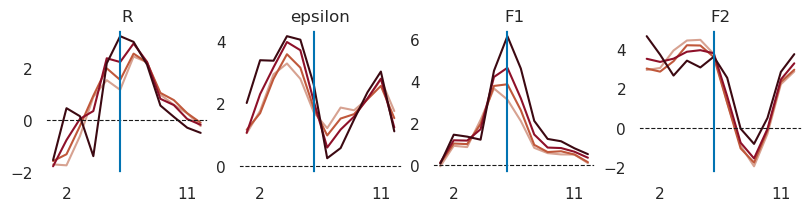

In [16]:
## specify colormap and norm
CMAP = cmocean.cm.amp
CMAP_NORM = plt.Normalize(vmin=-1, vmax=3)

## specify years to plot
YEARS = [1871, 2001, 2041, 2081]
# YEARS = [1871, 2021, 2081]
# YEARS = [1871, 1911, 1951, 1991]
# YEARS = [2021, 2041, 2061, 2081]

## Plot variance, noise, bjerknes index, and period
fig, axs = plt.subplots(1, 4, figsize=(10, 2.5), layout="constrained")

## plot data
for i, y in enumerate(YEARS):

    ## variance
    axs[0].plot(
        Th_std.month,
        Th_std[varnames[0]].sel(year=y, method="nearest").mean("member"),
        c=CMAP(CMAP_NORM(i)),
        label=y,
        lw=2,
    )

    ## noise/BJ
    for ax, p in zip(axs[1:], ["xi_T", "BJ_ac", "wyrtki"]):
        ax.plot(params.cycle, params[p].sel(year=y), c=CMAP(CMAP_NORM(i)), label=y)
        ax.set_title(p)


## formatting/label
format_params_line(axs)
axs[0].set_title(r"$\sigma(T)$")
axs[0].legend(prop=dict(size=10), loc="lower right")
axs[2].legend(prop=dict(size=10))  # , loc="upper left")

for ax in axs:
    ax.axvline(6)

plt.show()

## same, but for individual RO parameters
fig, axs = plt.subplots(1, 4, figsize=(8, 2), layout="constrained")

## loop thru parameters and years
for ax, p in zip(axs, ["R", "epsilon", "F1", "F2"]):
    for i, y in enumerate(YEARS):

        ## plot data
        ax.plot(params.cycle, params[p].sel(year=y), c=CMAP(CMAP_NORM(i)))

        ## formatting
        ax.set_title(p)


## formatting
format_params_line(axs)
for ax in axs:
    ax.axvline(6)
plt.show()

### Hovmoller plots for variance, growth rate, and noise

In [17]:
def format_params_hov(axs):
    """format hovmoller axes"""

    for ax in axs:
        ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
        ax.axvline(7, c="w", ls="--", lw=1, alpha=0.8)
        ax.set_xlabel("Month")
        ax.axhline(2025, c="w", ls="--", lw=1)

    axs[0].set_ylabel("Year")
    axs[0].set_yticks([1870, 1975, 2080])

    for ax in axs[1:]:
        ax.set_yticks([])
        ax.set_ylim(axs[0].get_ylim())

    return

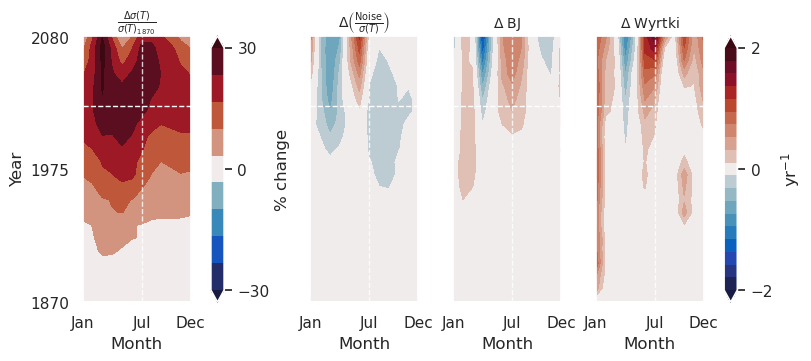

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3.5), layout="constrained")

#### plot change in std dev
plot_kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(30, 6), extend="both"
)

## plot data
cp0 = axs[0].contourf(
    delta_Th_std.month,
    delta_Th_std.year,
    delta_Th_std["T_3"].mean("member").transpose("year", ...),
    **plot_kwargs
)

##### plot change in model params

## specify plotting specs
plot_kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(2, 0.2), extend="both"
)

## plot data
cp1 = axs[1].contourf(
    params.cycle, params.year, delta_params["xi_T_norm"], **plot_kwargs
)
cp2 = axs[2].contourf(params.cycle, params.year, delta_params["BJ_ac"], **plot_kwargs)
cp3 = axs[3].contourf(params.cycle, params.year, delta_params["wyrtki"], **plot_kwargs)

## add colorbar
cb0 = fig.colorbar(cp0, label=r"% change", ticks=[-30, 0, 30])
cb1 = fig.colorbar(cp3, label=r"yr$^{-1}$", ticks=[-2, 0, 2])

## label])
axs[0].set_title(r"$\frac{\Delta \sigma(T)}{\sigma(T)_{1870}}$", size=10)
axs[1].set_title(r"$\Delta\left(\frac{\text{Noise}}{\sigma(T)}\right)$", size=10)
axs[2].set_title(r"$\Delta$ BJ", size=10)
axs[3].set_title(r"$\Delta$ Wyrtki", size=10)

## formatting
format_params_hov(axs)

plt.show()

### Same, but for RO parameters

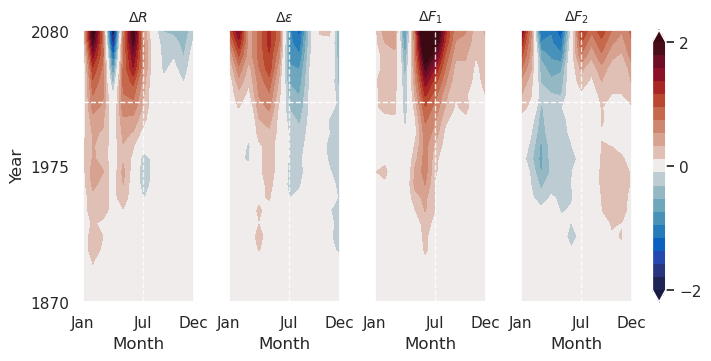

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(7, 3.5), layout="constrained")


##### plot change in model params

## specify plotting specs
plot_kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(2, 0.2), extend="both"
)

## plot data
cp0 = axs[0].contourf(params.cycle, params.year, delta_params["R"], **plot_kwargs)
cp1 = axs[1].contourf(params.cycle, params.year, delta_params["epsilon"], **plot_kwargs)
cp2 = axs[2].contourf(params.cycle, params.year, delta_params["F1"], **plot_kwargs)
cp3 = axs[3].contourf(params.cycle, params.year, delta_params["F2"], **plot_kwargs)

## add colorbar
cb1 = fig.colorbar(cp3, ticks=[-2, 0, 2])

## label
axs[0].set_ylabel("Year")
axs[0].set_yticks([1870, 1975, 2080])
axs[0].set_title(r"$\Delta R$", size=10)
axs[1].set_title(r"$\Delta \epsilon$", size=10)
axs[2].set_title(r"$\Delta F_1$", size=10)
axs[3].set_title(r"$\Delta F_2$", size=10)

## formatting
format_params_hov(axs)

plt.show()

### Change in annual-mean parameters over time

Plotting funcs

In [20]:
def plot_curve(ax, x, **plot_kwargs):
    """plot change in parameter over time on given ax"""
    plot_data = ax.plot(x.year, x, lw=2, **plot_kwargs)

    return plot_data


def format_pot_ax(ax):
    """add formatting to parameter-over-time plot"""
    ax.set_xlim([None, None])
    ax.legend(prop=dict(size=10), loc="upper left")
    ax.set_xticks([1870, 1975, 2080])
    ax.set_yticks([-0.5, 0, 0.5])
    ax.set_ylabel(r"year$^{-1}$")
    ax.set_xlabel("Year")
    ax.set_title(r"$\Delta \left(\text{RO parameters}\right)$")
    ax.axhline(0, c="k", ls="-", lw=0.5)
    return


def plot_pot0(ax, dp):
    """Plot change in parameters over time on ax object. 'dp' is change in params"""

    ## Plot Bjerknes growth rate
    plot_curve(ax, dp["BJ_ac"].mean("cycle"), c="k", label=r"BJ")
    plot_curve(ax, dp["wyrtki"].mean("cycle"), c="k", ls="--", label=r"wyrtki")

    ## plot noise
    plot_curve(
        ax,
        dp["xi_T_norm"].mean("cycle"),
        label=r"$\xi_T/\sigma_T$",
        c="darkgray",
    )
    plot_curve(
        ax, dp["xi_h_norm"].mean("cycle"), label=r"$\xi_h/\sigma_h$", c="lightgray"
    )

    ## set axis specs
    format_pot_ax(ax)

    return


def plot_pot1(ax, dp):
    """Plot change in parameters over time on ax object. 'dp' is change in params"""

    # Plot R, epsilon
    plot_curve(ax, dp["R"].mean("cycle"), label=r"$\overline{R}$")
    plot_curve(ax, dp["epsilon"].mean("cycle"), label=r"$\varepsilon$")

    # Plot F1, F2
    plot_curve(ax, dp["F1"].mean("cycle"), label=r"$F_1$", ls="--")
    plot_curve(ax, dp["F2"].mean("cycle"), label=r"$F_2$", ls="--")

    ## set axis specs
    format_pot_ax(ax)

    return

Make plot

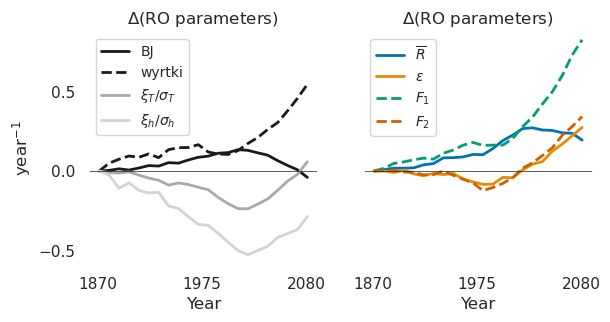

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3))

## plot change over time of parameters
plot_pot0(axs[0], dp=delta_params)
plot_pot1(axs[1], dp=delta_params)
axs[1].set_yticks([])
axs[1].set_ylabel(None)
# axs[0].axvline(2010)
src.utils.set_lims(axs)

plt.show()

## Sensitivity tests

### Get perturbed params

In [22]:
## should we fix the given parameter? or all others?
FIX_OTHERS = False
FIX_NOISE = False

## fixed BJ/Wyrtki
pparam_kwargs = dict(params=fits, fix_others=FIX_OTHERS, fix_noise=FIX_NOISE)
param_set_dict = {
    "control": fits,
    "noise": src.utils.get_perturbed_noise(fits, fix_others=FIX_OTHERS),
    # "BJ": src.utils.get_perturbed_multi(idxs=[(0, 0),(1,1)], **pparam_kwargs),
    "R": src.utils.get_perturbed_multi(idxs=[(0, 0)], **pparam_kwargs),
    "F1": src.utils.get_perturbed_multi(idxs=[(0, 1)], **pparam_kwargs),
    # "F2": src.utils.get_perturbed_multi(idxs=[(1, 0)], **pparam_kwargs),
    "eps": src.utils.get_perturbed_multi(idxs=[(1, 1)], **pparam_kwargs),
}

# ## get list of param sets and labels
param_sets = list(param_set_dict.values())
labels = list(param_set_dict.keys())

### plot perturbed params

In [23]:
def plot_param_set(ax, params, model):
    """plot parameter set over time for given experiment"""

    ## get named named params (nnual mean)
    params_ = model.get_RO_parameters(params).mean("cycle")

    ## plot core params
    for p in ["R", "epsilon", "F1", "F2"]:
        plot = ax.plot(params_.year, params_[p], label=p)
        ax.axhline(params_[p].isel(year=0), ls="--", c=plot[0].get_color(), lw=0.5)

    ## plot noise
    for p, c in zip(["xi_T", "xi_h"], ["gray", "lightgray"]):
        ax.plot(params_.year, params_[p], label=p, c=c)
        ax.axhline(params_[p].isel(year=0), ls="--", c=c, lw=0.5)

    ## format ax
    ax.set_xticks([1870, 2070])

    return

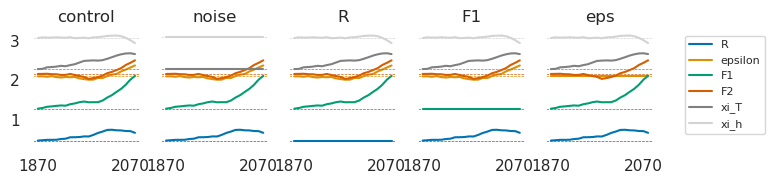

In [24]:
fig, axs = plt.subplots(1, len(labels), figsize=(1.6 * len(labels), 1.5))
for ax, param_set, label in zip(axs, param_sets, labels):
    plot_param_set(ax, param_set, model=MODEL)
    ax.set_title(label)

## formatting
for ax in axs[1:]:
    ax.set_yticks([])
    ax.set_ylim(axs[0].get_ylim())

## legend
axs[-1].legend(loc=(1.3, 0.1), prop=dict(size=8))

plt.show()

### Run simulations

In [25]:
## compute RO sigma over time for each experiment
exp_kwargs = dict(**simulation_kwargs, model=MODEL)
RO_sigma_exp = [get_RO_sigma_over_time(params=p, **exp_kwargs) for p in param_sets[1:]]

100%|██████████| 22/22 [00:05<00:00,  3.86it/s]


### Compute stats

In [26]:
## specify sum idxs (or set to None)
# SUM_IDXS = [-3, -2, -1]
SUM_IDXS = None

## Get stats
stats_control = get_stats(RO_sigma_over_time_v2)
stats_exp = [get_stats(x) for x in RO_sigma_exp]

## Get linearized sum of subset
if SUM_IDXS is not None:
    n = len(stats_exp)
    x0 = stats_control[varnames[0]].isel(year=0)
    stats_exp.append(x0 + sum([stats_exp[i] - x0 for i in SUM_IDXS]))

    if len(labels) == (len(stats_exp)):
        labels.append("(BJ & nse) + Wyrt.")

### Plot results

In [27]:
def format_row(axs, y0):
    """format row of plot in comparison"""

    ## label
    axs[0].set_yticks([np.round(sigma0, 1), np.round(sigma0 + 0.5, 1)])
    for ax in axs[1:]:
        ax.set_ylabel(None)
    axs[-1].set_ylabel(calendar.month_abbr[m])
    axs[-1].yaxis.set_label_position("right")
    for ax in axs:
        ax.axhline(y0, c="gray", lw=1, ls="--")
        ax.set_ylim([y0 - 0.3, y0 + 0.7])

    return


def format_subplots(axs, labels):
    """format all subplots"""
    for ax in axs[:-1].flatten():
        ax.set_xticks([])
        ax.set_xlabel(None)

    for ax in axs[:, 1:].flatten():
        ax.set_yticks([])

    for j in range(axs.shape[1]):
        axs[0, j].set_title(labels[j])

    return

#### All results

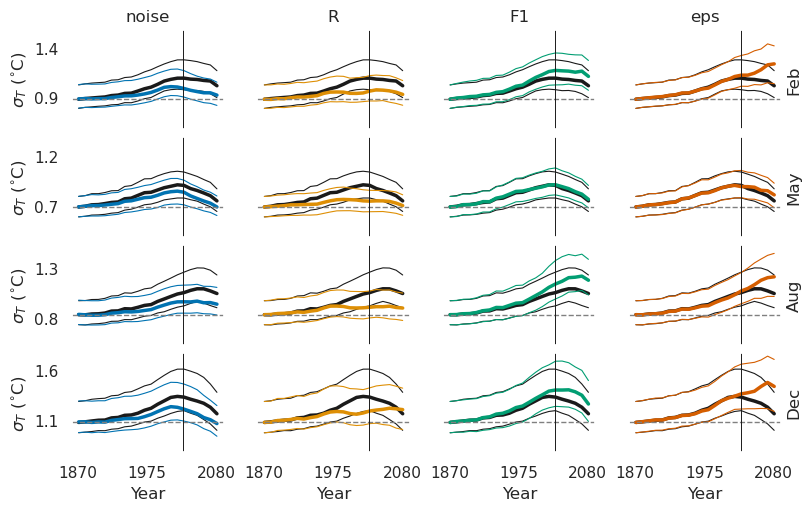

In [28]:
## specify which variable to plot
plot_var = varnames[0]

## plot results
n = len(stats_exp)
fig, axs = plt.subplots(4, n, figsize=(n * 2, 5), layout="constrained")

for i, m in enumerate([2, 5, 8, 12]):

    ## loop thru experiments
    for j in range(n):
        plot_stats_comp(
            axs[i, j],
            [stats_control.sel(month=m), stats_exp[j].sel(month=m)],
            labels=[labels[0], labels[j + 1]],
            colors=["k", sns.color_palette()[j]],
            n=plot_var,
        )

    ## get baseline value
    sigma0 = stats_control.sel(month=m)[plot_var].isel(q=1, year=0).values.item()

    ## format
    format_row(axs=axs[i], y0=sigma0)

## format all subplots
format_subplots(axs, labels=labels[1:])
for ax in axs.flatten():
    # ax.axvline(2050, lw=0.7, c="k")
    ax.axvline(2030, lw=0.7, c="k")

plt.show()

## Predictability

In [ ]:
## index
var_idx = 0

## predicted grad
X = Th_rolling[varnames].to_dataarray(dim="rankx")
Lac = fits["Lac"].rename({"cycle": "month"})
Lac = Lac.assign_coords({"month": np.arange(1, 13)})
Lac = Lac.assign_coords({"rankx": X.rankx, "ranky": X.rankx.values})
Yhat_ = (Lac * X.groupby("time.month")).sum("rankx").to_dataset("ranky")
Yhat = Yhat_[varnames[var_idx]]

## ground truth grad
Y_ = src.utils.get_ddt(Th_rolling[varnames], is_forward=IS_FORWARD)
Y = Y_[f"ddt_{varnames[var_idx]}"]

In [ ]:
## specify years to compare
# YEARS = [1871, 2051]
YEARS = [1871, 2081]

## specify month to plot
MONTH = 5

sel = lambda x: src.utils.sel_month(x, months=MONTH).transpose("year", "time", "member")
fig, axs = plt.subplots(1, 2, figsize=(6, 3), layout="constrained")

for ax, y in zip(axs, YEARS):

    xhat = sel(Yhat).sel(year=y)
    x = sel(Y).sel(year=y)
    print(y)
    print(f"corr: {xr.corr(xhat, x).values.item():.2f}")
    print(f"std:  {(xhat-x).std().values.item():.2f}")
    print()

    ax.scatter(
        sel(Yhat).sel(year=y),
        sel(Y).sel(year=y),
        s=3,
        alpha=0.5,
    )

    ## plot guidelines/axes
    Yrange = (
        sel(Yhat).sel(year=y).min().values.item(),
        sel(Yhat).sel(year=y).max().values.item(),
    )
    zz = np.linspace(*Yrange)
    axis_kwargs = dict(ls="--", c="k", lw=0.8, alpha=0.5)
    ax.axhline(0, **axis_kwargs)
    ax.axvline(0, **axis_kwargs)
    ax.plot(zz, zz, **dict(axis_kwargs, ls="-", alpha=0.8))

src.utils.set_lims(axs)
axs[1].set_yticks([])

plt.show()

In [ ]:
def regress(data, y_vars, x_vars, use_pinv=False):
    """
    Regress projected y_vars onto x_vars in given dataset
    """

    ## Get covariates and targets
    stack = lambda x: x.stack(sample=["time", "member"]).transpose(..., "sample")
    X = stack(data[x_vars].to_dataarray(dim="i"))
    Y = stack(data[y_vars].to_dataarray(dim="k"))

    ## compute
    coefs_values = Y.values @ np.linalg.pinv(X.values)
    coefs = xr.DataArray(coefs_values, coords=dict(i=X.i, j=Y.k), dims=["k", "i"])

    return coefs

In [ ]:
## variables to plot
v0 = varnames[1]
v1 = "T_34"

## months to plot
MONTHS = 6

## how to select data
sel = lambda x: src.utils.sel_month(x, months=MONTHS).transpose(
    "year", "time", "member"
)
# sel = lambda x: x.transpose("year", "time", "member")


fig, axs = plt.subplots(1, 2, figsize=(6, 3), layout="constrained")

for ax, y in zip(axs, YEARS):

    ## get data
    x0 = sel(Th_rolling[v0]).sel(year=y)
    x1 = sel(src.utils.get_ddt(Th_rolling[[v1]], is_forward=False)[f"ddt_{v1}"]).sel(
        year=y
    )

    ## plot
    ax.scatter(x0, x1, s=3, alpha=0.3)

    XY = xr.merge(
        [
            xr.ones_like(x0).rename("h0"),
            x0.rename("h"),
            (x0**2).rename("h2"),
            (x0**3).rename("h3"),
            x1.rename("dTdt"),
        ]
    )
    # coefs = regress(data=XY, x_vars=["h0", "h", "h2", "h3"], y_vars=["dTdt"])
    coefs = regress(data=XY, x_vars=["h0", "h", "h2"], y_vars=["dTdt"])
    zz = np.linspace(-2, 2)
    # ax.plot(
    #     zz,
    #     zz**3 * coefs.sel(i="h3").values
    #     + zz**2 * coefs.sel(i="h2").values
    #     + zz * coefs.sel(i="h").values
    #     + coefs.sel(i="h0").values,
    #     c="k",
    # )
    print(coefs)
    print()

    ## format plot
    axis_kwargs = dict(ls="--", c="k", lw=0.8, alpha=0.5)
    ax.axhline(0, **axis_kwargs)
    ax.axvline(0, **axis_kwargs)
    # ax.axvline(-2, **axis_kwargs)

src.utils.set_lims(axs)
axs[1].set_yticks([])

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3.5), layout="constrained")

for ax, year in zip(axs, YEARS):
    ax.scatter(
        sel(Th_rolling).sel(year=year)["T_34"],
        sel(Th_rolling).sel(year=year)[v0],
        s=3,
        alpha=0.5,
    )
src.utils.set_lims(axs)

In [ ]:
sel = lambda x: src.utils.sel_month(x, months=5).transpose("year", "time", "member")

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3), layout="constrained")


## plot data
for i, year in enumerate(YEARS):

    ## get datapoints
    xy = sel(Th_rolling).sel(year=year)
    x0 = xy[varnames[0]]
    x1 = xy[varnames[1]]

    ## rotate coords
    theta_deg = 60
    theta = np.deg2rad(theta_deg)
    sin = np.sin(theta)
    cos = np.cos(theta)
    x0_ = cos * x0 - sin * x1
    x1_ = sin * x0 + cos * x1
    # x0_ = np.sqrt(2)/2 * (x0 - x1)
    # x1_ = np.sqrt(2)/2 * (x0 + x1)

    # sel(Th_rolling[XVAR]).sel(year=y),

    ## get predicted velocities
    dx_hat = sel(Yhat_).sel(year=year)

    ## get actual velocities (and rename)
    dx = sel(Y_).sel(year=year).drop_vars(varnames)
    dx = dx.rename(dict(zip(list(dx), list(dx_hat))))

    ## get error
    err = dx - dx_hat

    ## plot data
    # axs[i].scatter(x0, x1, **sc_kwargs)

    ## plot velocities
    # axs[i].scatter(x0_, x1_, c=err[varnames[0]], cmap="cmo.balance", vmin=-10,vmax=10, s=15, alpha=.8)
    axs[i].scatter(x0_, err[varnames[1]], s=3, alpha=0.5)

    axs[i].axvline(0, c="k", lw=0.8)
    axs[i].axhline(0, c="k", lw=0.8)
    # axs[i].set_aspect("equal")

# ## plot tendencies
# axs[0].quiver(TT, hh, dTdt_early, dhdt_early, **qv_kwargs)
# axs[1].quiver(TT, hh, dTdt_late, dhdt_late, **qv_kwargs)

axs[1].set_yticks([])
src.utils.set_lims(axs)
plt.show()

In [ ]:
plt.hist(sel(Th_rolling)["h_w_z20"].sel(year=1871).values.flatten())
plt.hist(sel(Th_rolling)["h_w_z20"].sel(year=1991).values.flatten(), alpha=0.5)

In [ ]:
edges = np.arange(-19, 13, 2)
pdf0, _ = src.utils.get_empirical_pdf(
    sel(Y - Yhat).sel(year=1871).values.flatten(), edges=edges
)
pdf1, _ = src.utils.get_empirical_pdf(
    sel(Y - Yhat).sel(year=1991).values.flatten(), edges=edges
)
# plt.hist(sel(Y).sel(year=1871).values.flatten())
# plt.hist(sel(Y).sel(year=1991).values.flatten(), alpha=.5)
# plt.hist(sel(Th_rolling)["h_w_z20"].sel(year=1991).values.flatten(), alpha=.5)

In [ ]:
(pdf0 * 2 * edges[1:]).mean()
(pdf0 * 2 * edges[1:]).mean()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.stairs(pdf0, edges)
ax.stairs(pdf1, edges)

In [ ]:
plt.hist(sel(Th_rolling)["T_3"].sel(year=1871).values.flatten())
plt.hist(sel(Th_rolling)["T_3"].sel(year=1991).values.flatten(), alpha=0.5)

## Look at MLD scaling

In [ ]:
## load mixed layer depth EOFs
MLD_EOFS = src.utils.load_eofs(pathlib.Path(DATA_FP, "cesm", "eofs_mlotst.nc"))


def get_H(t_bnds):
    """get Niño 3.4 MLD for given bounds"""

    ## get scores in given subset of data
    scores_ = MLD_EOFS.scores().isel(time=slice(*t_bnds)).mean("member")

    ## get clim
    scores_clim = scores_.groupby("time.month").mean()

    ## reconstruct nino MLD
    mld = src.utils.reconstruct_fn(
        scores=scores_clim, components=MLD_EOFS.components(), fn=src.utils.get_nino34
    )

    return mld.rename({"month": "cycle"})


## get forced component
scores_mean = MLD_EOFS.scores().mean("member")

## compute MLD
H = src.utils.reconstruct_fn(
    scores=scores_mean.isel(time=slice(None, -1)),
    components=MLD_EOFS.components(),
    fn=src.utils.get_nino34,
)

## sep month/year
H = src.utils.unstack_month_and_year(H)

## smooth
H = H.rolling({"year": 31}, center=True).mean()
H = H.isel(year=slice(15, -15))

## get inverse MLD
beta = 1 / H

In [ ]:
## get fractional change
get_delta = lambda x: (x - x.isel(year=0)) / x.isel(year=0)
delta_beta = get_delta(beta.mean("month"))
delta_F2 = get_delta(params["F2"].mean("cycle"))
delta_eps = get_delta(params["epsilon"].mean("cycle"))
delta_R = get_delta(params["R"].mean("cycle"))
delta_wyrt = get_delta(params["wyrtki"].mean("cycle"))

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2.5), layout="constrained")

## plot data
ax.plot(
    delta_beta.year, delta_beta, label=r"$\frac{\Delta H^{-1}}{H^{-1}}$", c="k", lw=2
)
ax.plot(delta_F2.year, delta_F2, label=r"$\frac{\Delta F_2}{F_2}$")
ax.plot(delta_eps.year, delta_eps, label=r"$\frac{\Delta \varepsilon}{\varepsilon}$")
ax.plot(delta_wyrt.year, delta_wyrt, label=r"$\frac{\Delta Wyrtki}{Wyrtki}$")

## label
ax.set_ylabel("Fractional change")


ax.legend()
plt.show()

## Floquet analysis

In [ ]:
def get_L(fit, cycle_shift=np.arange(0, 1, 1 / 12)):
    """reconstruct linear operator from fit parameters and cycle (in range [0,1])"""

    ncycle = len(cycle_shift)
    ac_order = len(fit.ac_rank) - 1
    ncol = ac_order * 2 + 1
    rank_y = len(fit.ranky)
    rank_x = len(fit.rankx)
    omega = 2 * np.pi

    L_ac = np.zeros((rank_y, rank_x, ncycle))
    for i in range(rank_y):
        for j in range(rank_x):
            for m in range(ncol):

                ## dict for slicing
                sel_dict = dict(rankx=j, ranky=i, cossin=m)

                if m <= ac_order:
                    L_ac[i, j, :] = L_ac[i, j, :] + fit.Lcoef.isel(
                        sel_dict
                    ).values * np.cos(m * omega * cycle_shift)
                else:
                    mm = m - ac_order
                    L_ac[i, j, :] = L_ac[i, j, :] + fit.Lcoef.isel(
                        sel_dict
                    ).values * np.sin(mm * omega * cycle_shift)

    ## put in xarray
    cycle_coord = cycle_shift + cycle_shift[1] / 2
    L_ac = xr.DataArray(
        L_ac,
        coords=dict(ranky=fit.ranky, rankx=fit.rankx, cycle=cycle_coord),
        dims=["ranky", "rankx", "cycle"],
    )

    return L_ac


def integrate(L, x0, t0, tf, dt=1 / 2 * 1 / 365, save_hist=False, verbose=False):
    """integrate ode in time. L is a time-dependent function and
    x0 is the initial condition"""

    ## initialize and get time to integrate over
    x = x0
    time = np.arange(t0, tf, dt)

    ## define identity for convenience
    I = np.eye(2)

    ## empty array to hold results if desired
    if save_hist:
        x_hist = []

    ## integrate
    for t in tqdm.tqdm(time, disable=not (verbose)):
        x = (I + L(t) * dt) @ x

        ## save results if specified
        if save_hist:
            x_hist.append(x)

    if save_hist:
        return np.concatenate(x_hist, axis=1), time

    else:
        return x


def get_monodromy(L, dt=1 / 2 * 1 / 365, verbose=False):
    """Given time-dependent linear operator, construct monodromy matrix"""

    ## initial condition is identity matrix
    M0 = np.eye(2)

    ## integrate for one cycle
    M = integrate(L=L, x0=M0, t0=0, tf=1, dt=dt, verbose=verbose)

    return M


def get_timescales(fit, dt=1 / 365 * 1 / 2, verbose=False):
    """Get efolding timescale and period for given RO fit"""

    ## get cyclostationary operator
    L_cyc = get_L(fit, cycle_shift=np.arange(0, 1, dt))

    ## helper function to get numpy version based on time
    L_ = (
        lambda t: L_cyc.sel(cycle=t, method="nearest")
        .transpose("ranky", "rankx")
        .values
    )

    ## Get monodromy mat
    M = get_monodromy(L=L_, dt=dt, verbose=verbose)

    ## eigen-decomp
    w, _ = scipy.linalg.eig(M, left=False, right=True)

    ## get eigenvalues of linear operator
    gamma = np.log(w)
    sigma = gamma.real[0]
    omega = np.abs(gamma.imag)[0]

    ## compute timescales
    efold = -1 / sigma
    period = 2 * np.pi / omega

    return efold, period

In [ ]:
## check L reconstruction works
np.allclose(get_L(fits.isel(year=1)), fits.isel(year=1).Lac)

Func to compute timescales over time

In [ ]:
def get_timescales_over_time(fits_ot):
    """get timescales for time-varying fits"""

    ## empty list to hold results
    efolds = []
    periods = []

    ## loop thru years
    for y in tqdm.tqdm(fits_ot.year):
        efold, period = get_timescales(fits_ot.sel(year=y).squeeze())
        efolds.append(efold)
        periods.append(period)

    ## put in xr
    timescales = xr.Dataset(
        data_vars=dict(
            efold=("year", efolds),
            period=("year", periods),
        ),
        coords=dict(year=fits.year),
    )

    return timescales

Compute

In [ ]:
## get timescales
timescales_co = get_timescales_over_time(param_set_dict["control"])
timescales_bj = get_timescales_over_time(param_set_dict["BJ"])
timescales_wy = get_timescales_over_time(param_set_dict["Wyrtki"])

Plot control, two different ways

In [ ]:
def format_xaxis(ax):
    """add formatting to x axis"""
    ax.set_xlabel("Time")
    ax.set_xticks([1880, 2010, 2080])
    ax.axvline(2010, ls="--", c="gray", lw=0.8)

    return


## specify colors
colors = sns.color_palette("colorblind")[1:]
# colors = [colors[i] for i in [0,2]]


### Plot 1: same scale
fig, ax = plt.subplots(figsize=(3, 2.5), layout="constrained")

ax.plot(timescales_co.year, timescales_co["efold"], label=r"$e$-fold", c=colors[0])
ax.plot(timescales_co.year, timescales_co["period"], label="period", c=colors[1])

## formatting
ax.set_ylim([0, None])
ax.set_yticks([0, 2, 4])
ax.set_ylabel("year")
ax.legend(prop=dict(size=10))
format_xaxis(ax)

plt.show()


### Plot 2: different scales
fig, ax = plt.subplots(figsize=(3.5, 2.5), layout="constrained")

ax.plot(timescales_co.year, timescales_co["efold"], label=r"$e$-fold", c=colors[0])
ax.set_yticks([1.6, 2])
ax.set_ylabel(r"$e$-fold (yr)", color=colors[0])

ax2 = ax.twinx()
ax2.plot(timescales_co.year, timescales_co["period"], c=colors[1])
ax2.set_yticks([3, 3.8])
ax2.set_ylabel("period (yr)", color=colors[1])

## scale axes
ax.set_ylim([1.5, 2.0])
ax2.set_ylim([2.8, 3.8])

format_xaxis(ax)


plt.show()

Compare experiments

In [ ]:
### Plot 1: growth rate
fig, ax = plt.subplots(figsize=(3, 2.5), layout="constrained")

ax.plot(timescales_co.year, timescales_co["efold"], label="control", c="k")
ax.plot(timescales_co.year, timescales_bj["efold"], label="BJ", c=colors[0], ls="--")
ax.plot(
    timescales_co.year, timescales_wy["efold"], label="Wyrtki", c=colors[0], ls="-."
)

## formatting
ax.set_ylim([1.2, 2])
ax.set_yticks([1.6, 2])
ax.set_ylabel("year")
ax.legend(prop=dict(size=10))
format_xaxis(ax)

plt.show()

### Plot 2: period
fig, ax = plt.subplots(figsize=(3, 2.5), layout="constrained")

ax.plot(timescales_co.year, timescales_co["period"], label="control", c="k")
ax.plot(timescales_co.year, timescales_bj["period"], label="BJ", c=colors[1])
ax.plot(
    timescales_co.year, timescales_wy["period"], label="Wyrtki", c=colors[1], ls="-."
)

## formatting
ax.set_yticks([3, 3.8])
ax.set_ylim([2.4, 3.8])
ax.set_ylabel("year")
ax.legend(prop=dict(size=10))
format_xaxis(ax)

plt.show()

## Snapshots of seasonal changes, with variance

In [ ]:
def plot_mean_and_bounds(ax, x, show_bounds=True, **plot_kwargs):
    """print seasonal cycle of data in x on specified ax object"""

    ## plot ensemble mean
    plot_data = ax.plot(x.cycle, x.sel(posn="center"), lw=2, **plot_kwargs)

    ## plot bounds
    if show_bounds:
        kwargs = dict(c=plot_data[0].get_color(), ls="--", lw=0.5)
        for bound in ["upper", "lower"]:
            ax.plot(x.cycle, x.sel(posn=bound), **kwargs)

    return plot_data


def format_ax_and_twin(ax, ax_twin):
    """format ax as desired"""

    ax.set_title(y)
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
    ax.set_ylim([-3, 4.7])
    ax_twin.set_ylim([0, 2.2])
    ax.set_yticks([])
    ax_twin.set_yticks([])

    return

3 panels: BJ, noise, variance

In [ ]:
## expand "member" dim for backwards compat.
params_ = params.expand_dims("member")

stats_baseline = src.utils.get_ensemble_stats(params_.sel(year=1871, method="nearest"))
var_baseline = src.utils.get_ensemble_stats(
    Th_std.sel(year=1871, method="nearest")
).rename({"month": "cycle"})

## change in params between years
fig, axs = plt.subplots(1, 3, figsize=(7, 7 / 3))

## colors for different years
colors = sns.color_palette("mako")[::2]
years = [1871, 1971, 2071]
alphas = [1 / 4, 1, 1]

axs_twin = []
for j, (y, c, a) in enumerate(zip(years, colors, alphas)):

    ## twin axis for plotting variance
    axs_twin.append(axs[j].twinx())

    ## Get stats for year
    stats = src.utils.get_ensemble_stats(params_.sel(year=y, method="nearest"))
    var_stats = src.utils.get_ensemble_stats(
        Th_std.sel(year=y, method="nearest")
    ).rename({"month": "cycle"})

    ## plot baselines
    kwargs = dict(show_bounds=False, alpha=1 / 3)
    plot_mean_and_bounds(axs[j], x=stats_baseline["BJ_ac"], c="k", **kwargs)
    plot_mean_and_bounds(
        axs[j], x=stats_baseline["xi_T_norm"], c="k", ls="--", **kwargs
    )
    plot_mean_and_bounds(axs_twin[j], x=var_baseline["T_34"], c="r", **kwargs)

    ## get stats for new period
    plot_mean_and_bounds(axs[j], x=stats["BJ_ac"], c="k", alpha=a, label=r"$BJ$")
    plot_mean_and_bounds(
        axs[j], x=stats["xi_T_norm"], ls="--", c="k", alpha=a, label=r"$\xi_T/\sigma_T$"
    )
    plot_mean_and_bounds(
        axs_twin[j], x=var_stats["T_34"], c="r", alpha=a, label=r"$\sigma(T)$"
    )

    ## format axes
    format_ax_and_twin(axs[j], axs_twin[j])

axs[-1].legend(prop=dict(size=6), loc="upper right")
axs[0].set_yticks([-2, 0, 2, 4])
axs[0].set_ylabel(r"year$^{-1}$")
axs_twin[-1].set_yticks([0, 1], labels=[0, 1], color="r")
axs_twin[-1].set_ylabel(r"$\sigma_T$ ($^{\circ}$C)", color="r")

plt.show()